In [1]:
import pandas as pd
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import jieba
import jieba.analyse

import warnings
warnings.filterwarnings("ignore")

sns.set(style="darkgrid")
plt.rcParams['font.family'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
 
sns.set_style('whitegrid',{'font.sans-serif':['Arial Unicode MS','Arial']})

# 加载数据

In [2]:
data_raw=pd.read_csv('拉钩汇总.csv',names=['职能','公司','链接','职位','城市','工资','工作经验','学历'])
data_raw.shape

(4930, 8)

In [3]:
data_raw.head()

,职能,公司,链接,职位,城市,工资,工作经验,学历
0,产品,字节跳动,https://www.lagou.com/jobs/7683564.html,短视频高级产品经理,上海,35k-70k,不限,本科
1,产品,字节跳动,https://www.lagou.com/jobs/7762271.html,短视频后台高级产品经理,上海,25k-50k,3-5年,本科
2,产品,字节跳动,https://www.lagou.com/jobs/7762280.html,短视频高级产品经理-作者平台,上海,25k-50k,3-5年,本科
3,产品,字节跳动,https://www.lagou.com/jobs/7624918.html,AI数据平台项目经理,北京,15k-25k,1-3年,本科
4,产品,字节跳动,https://www.lagou.com/jobs/7480872.html,业务安全运营主管,北京,15k-25k,3-5年,本科


In [4]:
data_raw=data_raw[['职能','公司','职位','城市','工资','工作经验','学历']]

In [5]:
data_raw[['工资1','工资2']]=data_raw['工资'].str.split('-',expand=True)
data_raw['工资1']=data_raw['工资1'].str.split('k',expand=True)[0]
data_raw['工资2']=data_raw['工资2'].str.split('k',expand=True)[0]
data_raw[['经验1','经验2']]=data_raw['工作经验'].str.split('-',expand=True)
data_raw['经验2']=data_raw['经验2'].str.split('年',expand=True)[0]
data_raw=data_raw.drop(['工资','工作经验'],axis=1)

In [6]:
data_raw['经验1']=data_raw['经验1'].replace('不限',1)
data_raw['经验1']=data_raw['经验1'].replace('10年以上',10)
data_raw['经验1']=data_raw['经验1'].replace('1年以下',1)
data_raw['经验2']=data_raw['经验2'].fillna(1)

In [7]:
data_raw[['工资1','工资2','经验1','经验2']]=data_raw[['工资1','工资2','经验1','经验2']].astype('int')
data_raw['工资1/经验1']=data_raw['工资1']/data_raw['经验1']
data_raw['工资2/经验2']=data_raw['工资2']/data_raw['经验2']

## 取北上杭3个城市 

In [8]:
data_raw=data_raw[data_raw['城市'].isin(['上海','北京','杭州'])]

# 特征概览

In [9]:
print(
    '职能:',data_raw['职能'].unique(),'\n\n',
    '公司:',data_raw['公司'].unique(),'\n\n',
    '职位:',data_raw['职位'].unique(),'\n\n',
    '城市:',data_raw['城市'].unique(),'\n\n',
    '工资:',data_raw['工资1'].unique(),'\n\n',
    '工资:',data_raw['工资2'].unique(),'\n\n',
    '工资:',data_raw['经验1'].unique(),'\n\n',
    '工资:',data_raw['经验2'].unique(),'\n\n',
    '学历:',data_raw['学历'].unique())

职能: ['产品' '运营'] 

 公司: ['字节跳动' '美团点评' '阅文集团' '爱奇艺' '360' '小红书' '喜马拉雅' '平安金服' '平安科技'] 

 职位: ['短视频高级产品经理' '短视频后台高级产品经理' '短视频高级产品经理-作者平台' ... '1131HY-内容/社区/创作者管理运营'
 '11314Q-医学顾问（北京）' '11314P-医学顾问（上海）'] 

 城市: ['上海' '北京' '杭州'] 

 工资: [35 25 15 20 30 18 40 23 12 10  8 16 14 13 11 60 24  6 21 50 42 22 45  5
 28  3 27  9  2  7  4 17 36 32 26 55 80  1] 

 工资: [ 70  50  25  40  35  30  60  36  80  46  24  20  16  32  28  26  45  22
 100  15  12  11  75  55  65  10   7  27  23   5  18  17  13  14   8   4
   6  85  56  34  72  21  38  37  33  48  42 120   3   2] 

 工资: [ 1  3  5 10] 

 工资: [ 1  5  3 10] 

 学历: ['本科' '大专' '不限' '硕士']


In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3956 entries, 0 to 4927
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   职能       3956 non-null   object 
 1   公司       3956 non-null   object 
 2   职位       3956 non-null   object 
 3   城市       3956 non-null   object 
 4   学历       3956 non-null   object 
 5   工资1      3956 non-null   int64  
 6   工资2      3956 non-null   int64  
 7   经验1      3956 non-null   int64  
 8   经验2      3956 non-null   int64  
 9   工资1/经验1  3956 non-null   float64
 10  工资2/经验2  3956 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 370.9+ KB


In [11]:
data_raw.describe()

,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
count,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000
mean,19.516178,35.300303,2.198433,3.824570,12.386308,16.168301
std,7.872883,13.514924,1.310391,2.272145,9.091386,17.234566
min,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
25%,15.000000,28.000000,1.000000,1.000000,5.333333,6.000000
50%,20.000000,35.000000,3.000000,5.000000,8.333333,8.000000
75%,25.000000,40.000000,3.000000,5.000000,18.000000,16.666667
max,80.000000,120.000000,10.000000,10.000000,80.000000,100.000000


In [12]:
data_raw.head()

,职能,公司,职位,城市,学历,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
0,产品,字节跳动,短视频高级产品经理,上海,本科,35,70,1,1,35.000000,70.000000
1,产品,字节跳动,短视频后台高级产品经理,上海,本科,25,50,3,5,8.333333,10.000000
2,产品,字节跳动,短视频高级产品经理-作者平台,上海,本科,25,50,3,5,8.333333,10.000000
3,产品,字节跳动,AI数据平台项目经理,北京,本科,15,25,1,3,15.000000,8.333333
4,产品,字节跳动,业务安全运营主管,北京,本科,15,25,3,5,5.000000,5.000000


In [13]:
data_raw.shape

(3956, 11)

## 按城市/职能取pd

In [14]:
data_sh=data_raw[data_raw['城市']=='上海']
data_bj=data_raw[data_raw['城市']=='北京']
data_hz=data_raw[data_raw['城市']=='杭州']

In [15]:
oper_bj=data_bj[data_bj['职能']=='运营']
prod_bj=data_bj[data_bj['职能']=='产品']
oper_sh=data_sh[data_sh['职能']=='运营']
prod_sh=data_sh[data_sh['职能']=='产品']
oper_hz=data_hz[data_hz['职能']=='运营']
prod_hz=data_hz[data_hz['职能']=='产品']
prod_all=data_raw[data_raw['职能']=='产品']
oper_all=data_raw[data_raw['职能']=='运营']

# 总体数据分部

## 地理

In [16]:
print(
    'data_sh:','\n\n',data_sh.describe(),'\n\n',
    'data_bj:','\n\n',data_bj.describe(),'\n\n',
    'data_hz:','\n\n',data_hz.describe(),'\n\n',)

data_sh: 

               工资1         工资2         经验1         经验2     工资1/经验1     工资2/经验2
count  648.000000  648.000000  648.000000  648.000000  648.000000  648.000000
mean    20.131173   35.638889    2.370370    4.200617   12.010185   14.561728
std      8.242635   14.349981    1.455741    2.550243    9.049338   16.355251
min      1.000000    2.000000    1.000000    1.000000    1.000000    1.500000
25%     15.000000   25.750000    1.000000    3.000000    5.000000    6.000000
50%     20.000000   35.000000    3.000000    5.000000    8.333333    8.000000
75%     25.000000   40.000000    3.000000    5.000000   15.000000   13.333333
max     60.000000  120.000000   10.000000   10.000000   60.000000  100.000000 

 data_bj: 

                工资1          工资2          经验1          经验2      工资1/经验1  \
count  3223.000000  3223.000000  3223.000000  3223.000000  3223.000000   
mean     19.426311    35.273348     2.167546     3.757989    12.473358   
std       7.774927    13.283989     1.282979     

### 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1'>

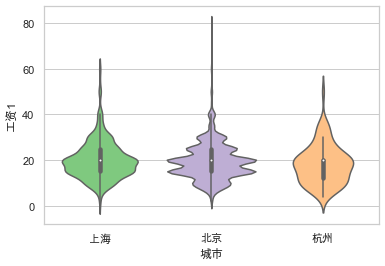

In [17]:
sns.violinplot(x="城市",y="工资1",palette="Accent",data=data_raw,saturation=1)

### 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2'>

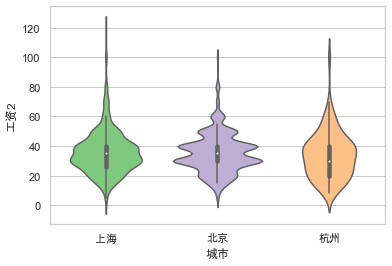

In [18]:
sns.violinplot(x="城市",y="工资2",palette="Accent",data=data_raw,saturation=1)

In [19]:
data_raw

,职能,公司,职位,城市,学历,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
0,产品,字节跳动,短视频高级产品经理,上海,本科,35,70,1,1,35.000000,70.000000
1,产品,字节跳动,短视频后台高级产品经理,上海,本科,25,50,3,5,8.333333,10.000000
2,产品,字节跳动,短视频高级产品经理-作者平台,上海,本科,25,50,3,5,8.333333,10.000000
3,产品,字节跳动,AI数据平台项目经理,北京,本科,15,25,1,3,15.000000,8.333333
4,产品,字节跳动,业务安全运营主管,北京,本科,15,25,3,5,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...
4918,产品,平安科技,产品经理,上海,本科,15,28,3,5,5.000000,5.600000
4919,产品,平安科技,资深产品经理,上海,硕士,26,30,3,5,8.666667,6.000000
4924,运营,平安科技,1131HY-内容/社区/创作者管理运营,上海,本科,15,30,3,5,5.000000,6.000000
4926,运营,平安科技,11314Q-医学顾问（北京）,北京,硕士,20,30,3,5,6.666667,6.000000


### 性价比 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1/经验1'>

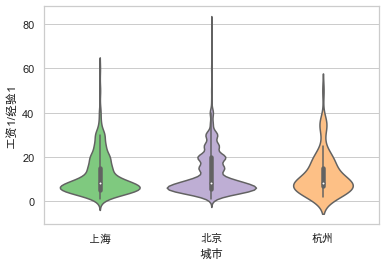

In [20]:
sns.violinplot(x="城市",y="工资1/经验1",palette="Accent",data=data_raw,saturation=1)

### 性价比 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2/经验2'>

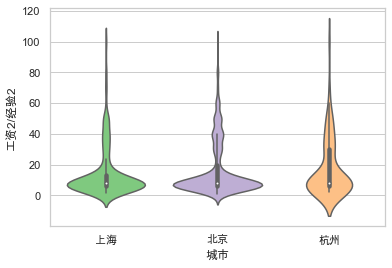

In [21]:
sns.violinplot(x="城市",y="工资2/经验2",palette="Accent",data=data_raw,saturation=1)

## 职能

In [22]:
print(
    'oper_bj:','\n\n',oper_bj.describe(),'\n\n',
    'prod_bj:','\n\n',prod_bj.describe(),'\n\n',
    'oper_sh:','\n\n',oper_sh.describe(),'\n\n',
    'prod_sh:','\n\n',prod_sh.describe(),'\n\n',
    'oper_hz:','\n\n',oper_hz.describe(),'\n\n',
    'prod_hz:','\n\n',prod_hz.describe(),'\n\n',
    'prod_all:','\n\n',prod_all.describe(),'\n\n',
    'oper_all:','\n\n',oper_all.describe(),'\n\n',
)

oper_bj: 

                工资1          工资2          经验1          经验2      工资1/经验1  \
count  1798.000000  1798.000000  1798.000000  1798.000000  1798.000000   
mean     17.275306    31.432703     2.048387     3.583982    11.629088   
std       7.685554    13.094820     1.211334     2.076556     8.729665   
min       2.000000     4.000000     1.000000     1.000000     1.000000   
25%      12.000000    20.000000     1.000000     1.000000     5.000000   
50%      15.000000    30.000000     1.000000     3.000000     8.333333   
75%      20.000000    40.000000     3.000000     5.000000    15.000000   
max      80.000000   100.000000    10.000000    10.000000    80.000000   

           工资2/经验2  
count  1798.000000  
mean     15.365128  
std      16.658096  
min       1.000000  
25%       5.600000  
50%       7.200000  
75%      20.000000  
max     100.000000   

 prod_bj: 

                工资1          工资2          经验1          经验2      工资1/经验1  \
count  1425.000000  1425.000000  1425.00000

### pord 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1'>

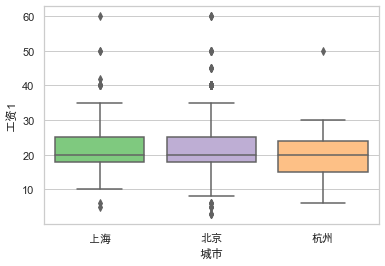

In [23]:
sns.boxplot(x="城市",y="工资1",palette="Accent",data=prod_all,saturation=1)

### prod 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2'>

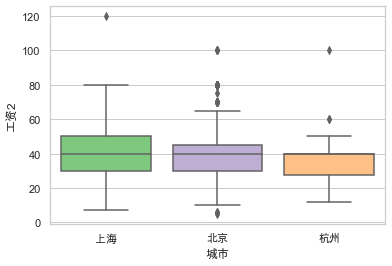

In [24]:
sns.boxplot(x="城市",y="工资2",palette="Accent",data=prod_all,saturation=1)

### prod 性价比 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1/经验1'>

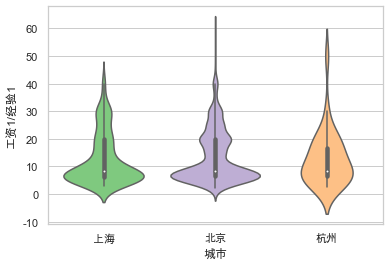

In [25]:
sns.violinplot(x="城市",y="工资1/经验1",palette="Accent",data=prod_all,saturation=1)

### prod 性价比 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2/经验2'>

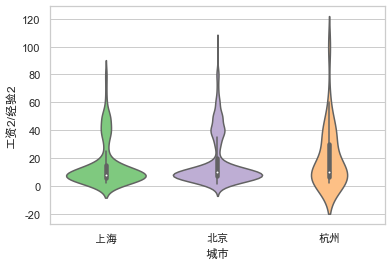

In [26]:
sns.violinplot(x="城市",y="工资2/经验2",palette="Accent",data=prod_all,saturation=1)

### oper 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1'>

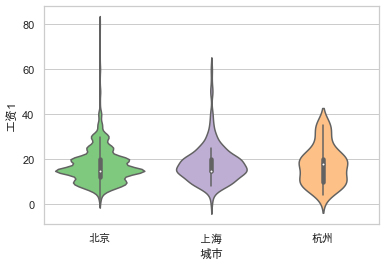

In [27]:
sns.violinplot(x="城市",y="工资1",palette="Accent",data=oper_all,saturation=1)

### oper 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2'>

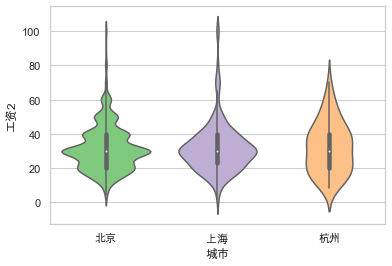

In [28]:
sns.violinplot(x="城市",y="工资2",palette="Accent",data=oper_all,saturation=1)

### oper 性价比 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1/经验1'>

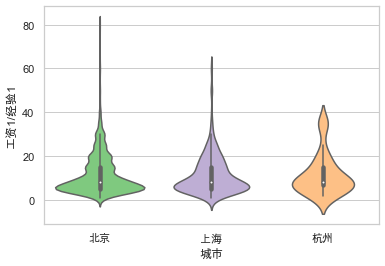

In [29]:
sns.violinplot(x="城市",y="工资1/经验1",palette="Accent",data=oper_all,saturation=1)

### oper 性价比 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2/经验2'>

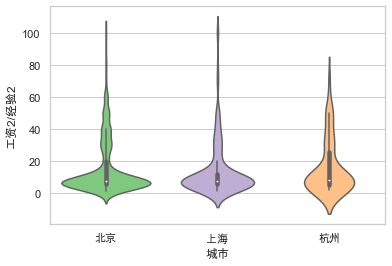

In [30]:
sns.violinplot(x="城市",y="工资2/经验2",palette="Accent",data=oper_all,saturation=1)

# 职位分部

## 数据

In [31]:
data_prod_sh=prod_sh[prod_sh['职位'].str.contains('数据')]
data_oper_sh=oper_sh[oper_sh['职位'].str.contains('数据')]

data_prod_hz=prod_hz[prod_hz['职位'].str.contains('数据')]
data_oper_hz=oper_hz[oper_hz['职位'].str.contains('数据')]

data_prod_bj=prod_bj[prod_bj['职位'].str.contains('数据')]
data_oper_bj=oper_bj[oper_bj['职位'].str.contains('数据')]

data_prod_all=prod_all[prod_all['职位'].str.contains('数据')]
data_oper_all=oper_all[oper_all['职位'].str.contains('数据')]

In [32]:
print(
    'data_oper_bj:','\n\n',data_prod_bj.describe(),'\n\n',
    'data_prod_bj:','\n\n',data_oper_bj.describe(),'\n\n',
    
    'data_oper_sh:','\n\n',data_oper_sh.describe(),'\n\n',
    'data_prod_sh:','\n\n',data_prod_sh.describe(),'\n\n',
    
    'data_oper_hz:','\n\n',data_oper_hz.describe(),'\n\n',
    'data_prod_hz:','\n\n',data_prod_hz.describe(),'\n\n',
    
    'data_prod_all:','\n\n',data_prod_all.describe(),'\n\n',
    'data_oper_all:','\n\n',data_oper_all.describe(),'\n\n',
    
)

data_oper_bj: 

               工资1         工资2         经验1         经验2     工资1/经验1     工资2/经验2
count  222.000000  222.000000  222.000000  222.000000  222.000000  222.000000
mean    19.846847   36.882883    2.148649    3.725225   12.677177   16.883033
std      6.078220   11.145065    1.290576    2.192375    7.700358   16.076216
min      6.000000   10.000000    1.000000    1.000000    3.000000    3.000000
25%     15.000000   30.000000    1.000000    1.000000    6.666667    6.000000
50%     20.000000   35.000000    3.000000    5.000000   10.000000   10.000000
75%     25.000000   40.000000    3.000000    5.000000   20.000000   30.000000
max     50.000000   80.000000   10.000000   10.000000   40.000000   80.000000 

 data_prod_bj: 

              工资1        工资2        经验1        经验2    工资1/经验1    工资2/经验2
count  71.000000  71.000000  71.000000  71.000000  71.000000  71.000000
mean   14.676056  27.309859   1.957746   3.690141  10.024413  11.159624
std     5.800923  10.495702   1.164187   2.00

### oper 数据 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1'>

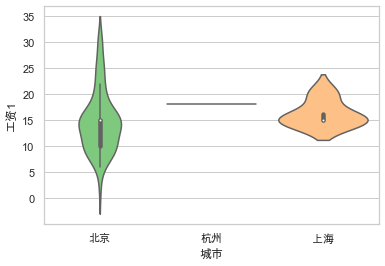

In [33]:
sns.violinplot(x="城市",y="工资1",palette="Accent",data=data_oper_all,saturation=1)

### oper 数据 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2'>

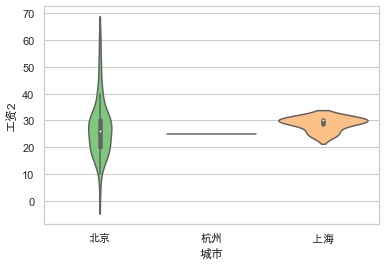

In [34]:
sns.violinplot(x="城市",y="工资2",palette="Accent",data=data_oper_all,saturation=1)

### oper 性价比 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1/经验1'>

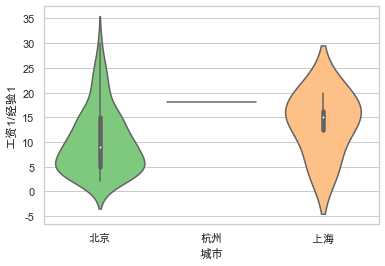

In [35]:
sns.violinplot(x="城市",y="工资1/经验1",palette="Accent",data=data_oper_all,saturation=1)

### oper 性价比 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2/经验2'>

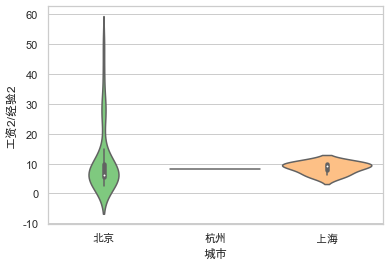

In [36]:
sns.violinplot(x="城市",y="工资2/经验2",palette="Accent",data=data_oper_all,saturation=1)

### prod 数据 工资2

<AxesSubplot:xlabel='城市', ylabel='工资1'>

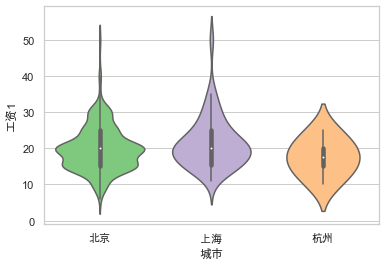

In [37]:
sns.violinplot(x="城市",y="工资1",palette="Accent",data=data_prod_all,saturation=1)

### prod 数据 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2'>

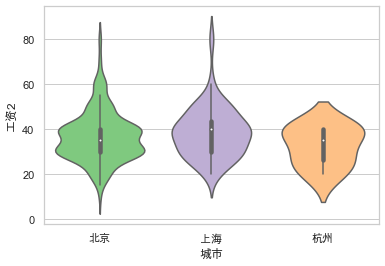

In [38]:
sns.violinplot(x="城市",y="工资2",palette="Accent",data=data_prod_all,saturation=1)

### prod 性价比 工资1

<AxesSubplot:xlabel='城市', ylabel='工资1/经验1'>

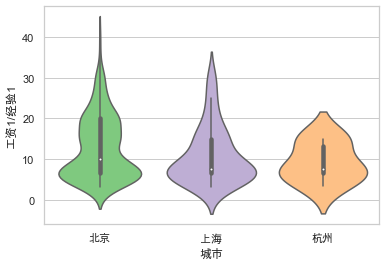

In [39]:
sns.violinplot(x="城市",y="工资1/经验1",palette="Accent",data=data_prod_all,saturation=1)

### prod 性价比 工资2

<AxesSubplot:xlabel='城市', ylabel='工资2/经验2'>

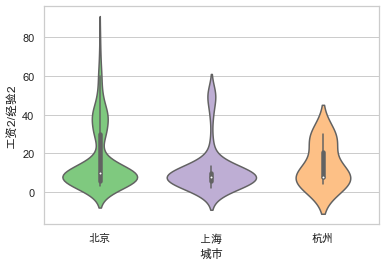

In [40]:
sns.violinplot(x="城市",y="工资2/经验2",palette="Accent",data=data_prod_all,saturation=1)

## 用户

In [41]:
posi_prod_sh=prod_sh[prod_sh['职位'].str.contains('用户')]
posi_oper_sh=oper_sh[oper_sh['职位'].str.contains('用户')]

posi_prod_hz=prod_hz[prod_hz['职位'].str.contains('用户')]
pos_oper_hz=oper_hz[oper_hz['职位'].str.contains('用户')]

posi_prod_bj=prod_bj[prod_bj['职位'].str.contains('用户')]
posi_oper_bj=oper_bj[oper_bj['职位'].str.contains('用户')]

posi_prod_all=prod_all[prod_all['职位'].str.contains('用户')]
posi_oper_all=oper_all[oper_all['职位'].str.contains('用户')]

In [42]:
print(
    'posi_prod_sh:','\n\n',posi_prod_sh.describe(),'\n\n',
    'posi_oper_sh:','\n\n',posi_oper_sh.describe(),'\n\n',
    
    'posi_prod_hz:','\n\n',posi_prod_hz.describe(),'\n\n',
    'pos_oper_hz:','\n\n',pos_oper_hz.describe(),'\n\n',
    
    'posi_prod_bj:','\n\n',posi_prod_bj.describe(),'\n\n',
    'posi_oper_bj:','\n\n',posi_oper_bj.describe(),'\n\n',
    
    'posi_prod_all:','\n\n',posi_prod_all.describe(),'\n\n',
    'posi_oper_all:','\n\n',posi_oper_all.describe(),'\n\n',
    
)

posi_prod_sh: 

              工资1        工资2        经验1        经验2    工资1/经验1    工资2/经验2
count  21.000000  21.000000  21.000000  21.000000  21.000000  21.000000
mean   25.809524  44.666667   2.619048   4.904762  14.698413  15.428571
std     6.982972   9.073772   1.499206   2.896632  11.106507  16.943499
min    15.000000  30.000000   1.000000   1.000000   4.000000   4.000000
25%    20.000000  40.000000   1.000000   3.000000   6.666667   8.000000
50%    25.000000  40.000000   3.000000   5.000000   8.333333   8.000000
75%    30.000000  50.000000   3.000000   5.000000  25.000000  15.000000
max    42.000000  70.000000   5.000000  10.000000  42.000000  70.000000 

 posi_oper_sh: 

              工资1        工资2        经验1        经验2    工资1/经验1    工资2/经验2
count  24.000000  24.000000  24.000000  24.000000  24.000000  24.000000
mean   22.208333  38.625000   2.583333   4.583333  10.875000  11.459722
std     9.956336  13.229784   1.176460   2.185260   7.124709  10.480845
min    12.000000  22.000000

## 增长

In [43]:
posi_prod_sh=prod_sh[prod_sh['职位'].str.contains('增长')]
posi_oper_sh=oper_sh[oper_sh['职位'].str.contains('增长')]

posi_prod_hz=prod_hz[prod_hz['职位'].str.contains('增长')]
pos_oper_hz=oper_hz[oper_hz['职位'].str.contains('增长')]

posi_prod_bj=prod_bj[prod_bj['职位'].str.contains('增长')]
posi_oper_bj=oper_bj[oper_bj['职位'].str.contains('增长')]

posi_prod_all=prod_all[prod_all['职位'].str.contains('增长')]
posi_oper_all=oper_all[oper_all['职位'].str.contains('增长')]

In [44]:
print(
    'posi_prod_sh:','\n\n',posi_prod_sh.describe(),'\n\n',
    'posi_oper_sh:','\n\n',posi_oper_sh.describe(),'\n\n',
    
    'posi_prod_hz:','\n\n',posi_prod_hz.describe(),'\n\n',
    'pos_oper_hz:','\n\n',pos_oper_hz.describe(),'\n\n',
    
    'posi_prod_bj:','\n\n',posi_prod_bj.describe(),'\n\n',
    'posi_oper_bj:','\n\n',posi_oper_bj.describe(),'\n\n',
    
    'posi_prod_all:','\n\n',posi_prod_all.describe(),'\n\n',
    'posi_oper_all:','\n\n',posi_oper_all.describe(),'\n\n',
    
)

posi_prod_sh: 

              工资1        工资2        经验1        经验2    工资1/经验1    工资2/经验2
count  16.000000  16.000000  16.000000  16.000000  16.000000  16.000000
mean   24.375000  41.937500   2.875000   5.375000  12.250000  11.947917
std     5.439056  10.642486   1.543805   3.074085   8.972798  11.418030
min    15.000000  25.000000   1.000000   1.000000   3.000000   3.000000
25%    20.000000  35.000000   1.000000   3.000000   6.500000   6.300000
50%    25.000000  40.000000   3.000000   5.000000   8.333333   8.000000
75%    30.000000  50.000000   3.500000   6.250000  16.250000  12.166667
max    30.000000  60.000000   5.000000  10.000000  30.000000  50.000000 

 posi_oper_sh: 

              工资1       工资2        经验1        经验2    工资1/经验1    工资2/经验2
count  13.000000  13.00000  13.000000  13.000000  13.000000  13.000000
mean   22.000000  42.00000   2.846154   5.000000   9.897436  13.848718
std     7.505553  12.95505   1.281025   2.677063   7.135442  16.109789
min    13.000000  25.00000   1.

In [45]:
paragraph=''
for word in data_raw['职位'].unique().tolist():
    paragraph+=word

# 工资纵览

## nlp

In [46]:
key_posi_word=jieba.analyse.extract_tags(paragraph, topK=100, withWeight=False, allowPOS=('n','a','v','an','ad'))
str(key_posi_word)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/67/9k7yyqxx0rs5fps69_yk5cp00000gn/T/jieba.cache
Loading model cost 0.753 seconds.
Prefix dict has been built successfully.


"['经理', '产品', '方向', '电商', '策略', '用户', '专家', '视频', '内容', '资深', '平台', '商业', '数据', '广告', '游戏', '专员', '负责人', '分析师', '增长', '商家', '商业化', '业务', '社区', '审核', '头条', '搜索', '项目经理', '外卖', '生态', '闪购', '创作者', '策划', '后台', '行业', '客户', '项目管理', '渠道', '引擎', '质量', '打车', '安全', '总监', '企业应用', '火山', '体验', '客服', '运营部', '解决方案', '流量', '战略', '配送', '供应链', '门票', '品类', '智能', '品牌', '垂直', '支持', '媒体', '工具', '优选', '垂类', '点评', '中心', '业务部', '编辑', '主管', '视频产品', '社群', '系统', '支付', '治理', '事业部', '医药', '类目', '项目', '赋能', '企业', '度假', '买菜', '商品', '培训师', '金融', '架构师', '音乐', '创意', '小说', '工程师', '版权', '汽车', '信息流', '频道', '实习生', '安全策略', '财务', '星图', '流程', '变现', '售前', '商务']"

In [47]:
key_posi_word=jieba.analyse.extract_tags(paragraph, topK=50, withWeight=False, allowPOS=())
str(key_posi_word)

"['运营', '经理', '产品', '方向', '电商', '高级', '策略', '用户', '专家', '视频', '内容', '美团', '资深', '平台', '商业', '数据', '直播', '广告', '游戏', '专员', '负责人', '分析师', '抖音', '国际化', '增长', '商家', '商业化', '业务', '分析', 'SG', '社区', '营销', '审核', '头条', '管理', '搜索', '--', '项目经理', '教育', '外卖', '生态', '闪购', '创作者', '策划', '风控', '后台', 'AI', 'PMO', '行业', '销售']"

### 手动添加 

In [142]:
# 行业
key_posi_word_1=[
    '视频', '供应链', '支付', '打车',  'SaaS', 'Resso', '算法', '安全', 
    '抖音', '商业化', '客户', 'AI', '商品', '医药', '配送','用户增长',
   '中台', '国际化', '企业应用', '质量', '编辑', '闪购', '审核', '频道', '后台', '媒体', '架构师', 
    '商家', '火山', '类目', '会员', '游戏', '云计算', '智能', '度假', '中心',  '搜索',
    '广告', '平台', '直播', '客服', '门票', '商业', '小说', '社区',  '金融',  '商务',
    '安全策略', '数据', '工具', '策略', '版权', '头条',  '策划', '社群', '品类', '信息流', '星图', '渠道', 
    '体验', '事业部', '买菜', '创作者', '音乐', '战略', '工程师', '垂直', '主管', '流量', '外卖', '培训师',
    '汽车', '视频产品', '点评', '内容' , '变现', '项目', '财务', '电商']
key_posi_word_2=['实习','专员','高级','资深','专家','总监','负责人',]
key_posi_word_3=[
    '视频', '供应链', '支付', '项目管理', '生态', '打车', '项目经理', 'SaaS', 'Resso', '算法', '安全', '产品', '企业',
    '抖音', '商业化', '客户', 'AI', '商品', '医药', '负责人', '治理', '业务', '售前', '分析师', '行业', '创意', '配送',
    '品牌', '中台', '国际化', '业务部', '企业应用', '质量', '编辑', '闪购', '审核', '频道', '后台', '媒体', '架构师', 
    '商家', '火山', '类目', '会员', '引擎', '游戏', '云计算', '智能', '资深', '度假', '中心', '解决方案', '支持', '搜索',
    '广告', '平台', '直播', '客服', '经理', '门票', '商业', '增长', '小说', '方向', '社区', '专员', '金融', '运营部', '商务',
    '安全策略', '数据', '工具', '策略', '优选', '版权', '头条', '赋能', '策划', '社群', '品类', '信息流', '星图', '渠道', 
    '体验', '垂类', '事业部', '买菜', '创作者', '音乐', '战略', '工程师', '垂直', '主管', '流量', '商业质量', '外卖', '培训师',
    '汽车', '视频产品', '点评', '内容', '总监', '用户', '变现', '专家', '项目', '财务', '实习生', '系统', '流程', '电商']
key_posi_word_4=[
    '视频', '供应链', '支付', '项目管理', '生态', '打车', '项目经理', 'SaaS', 'Resso', '算法', '安全', '产品', '企业',
    '抖音', '商业化', '客户', 'AI', '商品', '医药', '负责','优选','人', '治理', '业务', '售前', '分析师', '行业', '创意', '配送',
    '品牌', '中台', '国际化', '业务部', '企业应用', '质量', '编辑', '闪购', '审核', '频道', '后台', '媒体', '架构师', 
    '商家', '火山', '类目', '会员', '引擎', '游戏', '云计算', '智能', '资深', '度假', '中心', '解决方案', '支持', '搜索',
    '广告', '平台', '直播', '客服', '经理', '门票', '商业', '增长', '小说', '方向', '社区', '专员', '金融', '运营部', '商务',
    '安全策略', '数据', '工具', '策略', '优选', '版权', '头条', '赋能', '策划', '社群', '品类', '信息流', '星图', '渠道', 
    '体验', '垂类', '事业部', '买菜', '创作者', '音乐', '战略', '工程师', '垂直', '主管', '流量', '商业质量', '外卖', '培训师',
    '汽车', '视频产品', '点评', '内容', '总监', '用户', '变现', '专家', '项目', '财务', '实习生', '系统', '流程', '电商']

In [143]:
posi_data_prod_pd=data_raw[data_raw.loc[:,'职能']=='产品'].copy()
posi_data_oper_pd=data_raw[data_raw.loc[:,'职能']=='运营'].copy()
posi_data_all_pd=data_raw.copy()

for posi in key_posi_word_1:
    index_all=data_raw.loc[data_raw.loc[:,'职位'].str.contains(posi),:].index
    index_prod=posi_data_prod_pd.loc[posi_data_prod_pd.loc[:,'职位'].str.contains(posi),:].index
    index_oper=posi_data_oper_pd.loc[posi_data_oper_pd.loc[:,'职位'].str.contains(posi),:].index
    posi_data_all_pd.loc[index_all,'职位']=posi    
    posi_data_prod_pd.loc[index_prod,'职位']=posi
    posi_data_oper_pd.loc[index_oper,'职位']=posi

### 全部职位 工资1

<AxesSubplot:xlabel='职位', ylabel='工资1'>

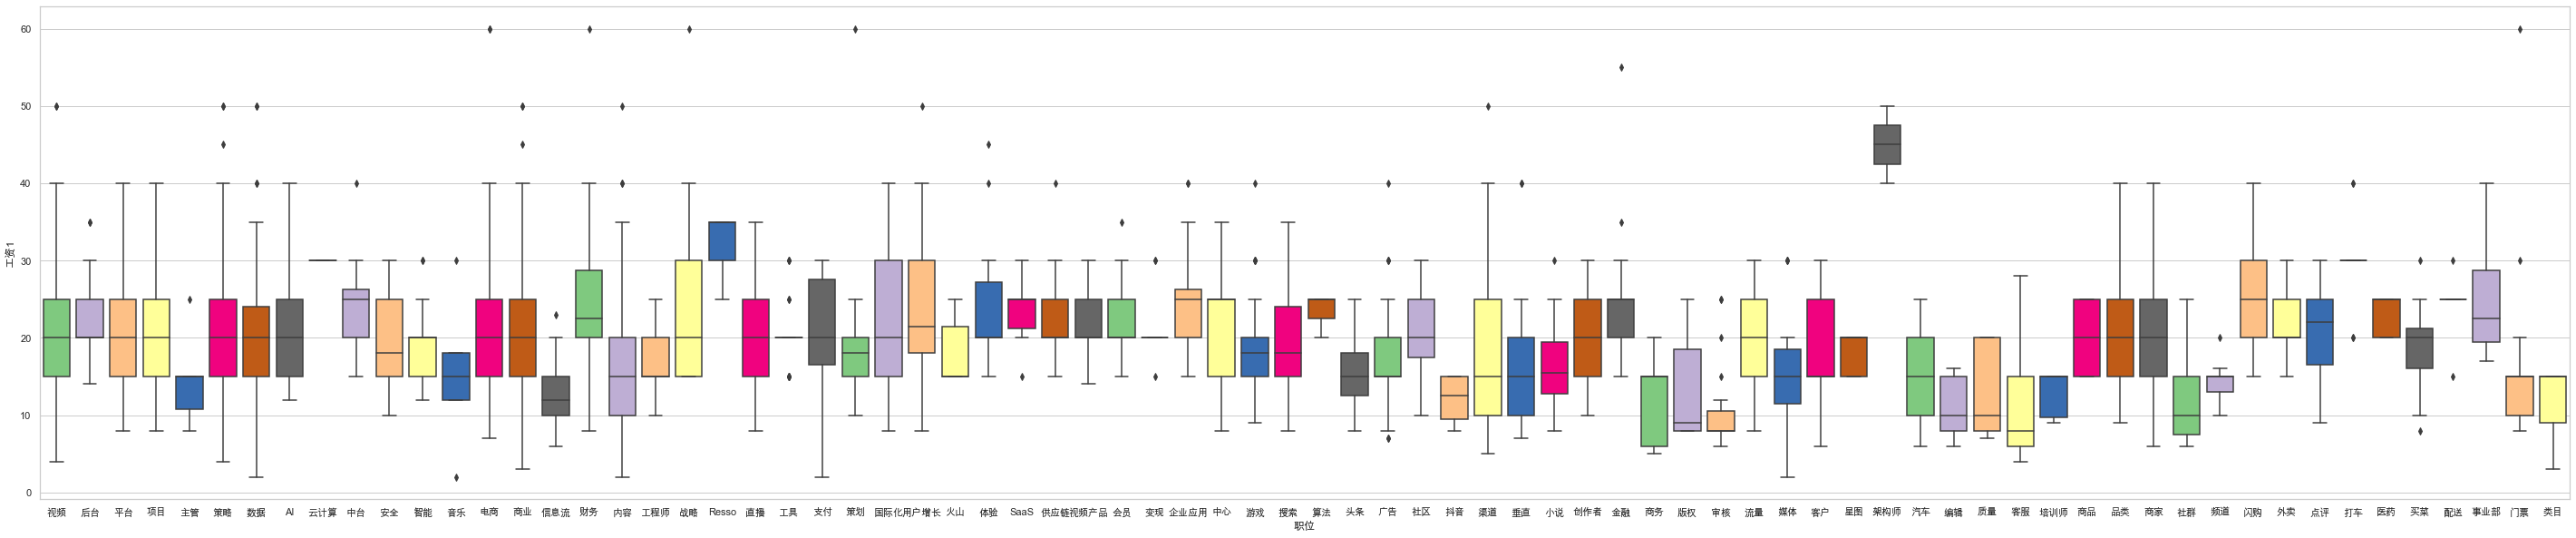

In [144]:
posi_pd_graph=posi_data_all_pd[posi_data_all_pd['职位'].isin(key_posi_word_1)]

plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资1",palette="Accent",data=posi_pd_graph,saturation=1)

### 全部职位 工资2

<AxesSubplot:xlabel='职位', ylabel='工资2'>

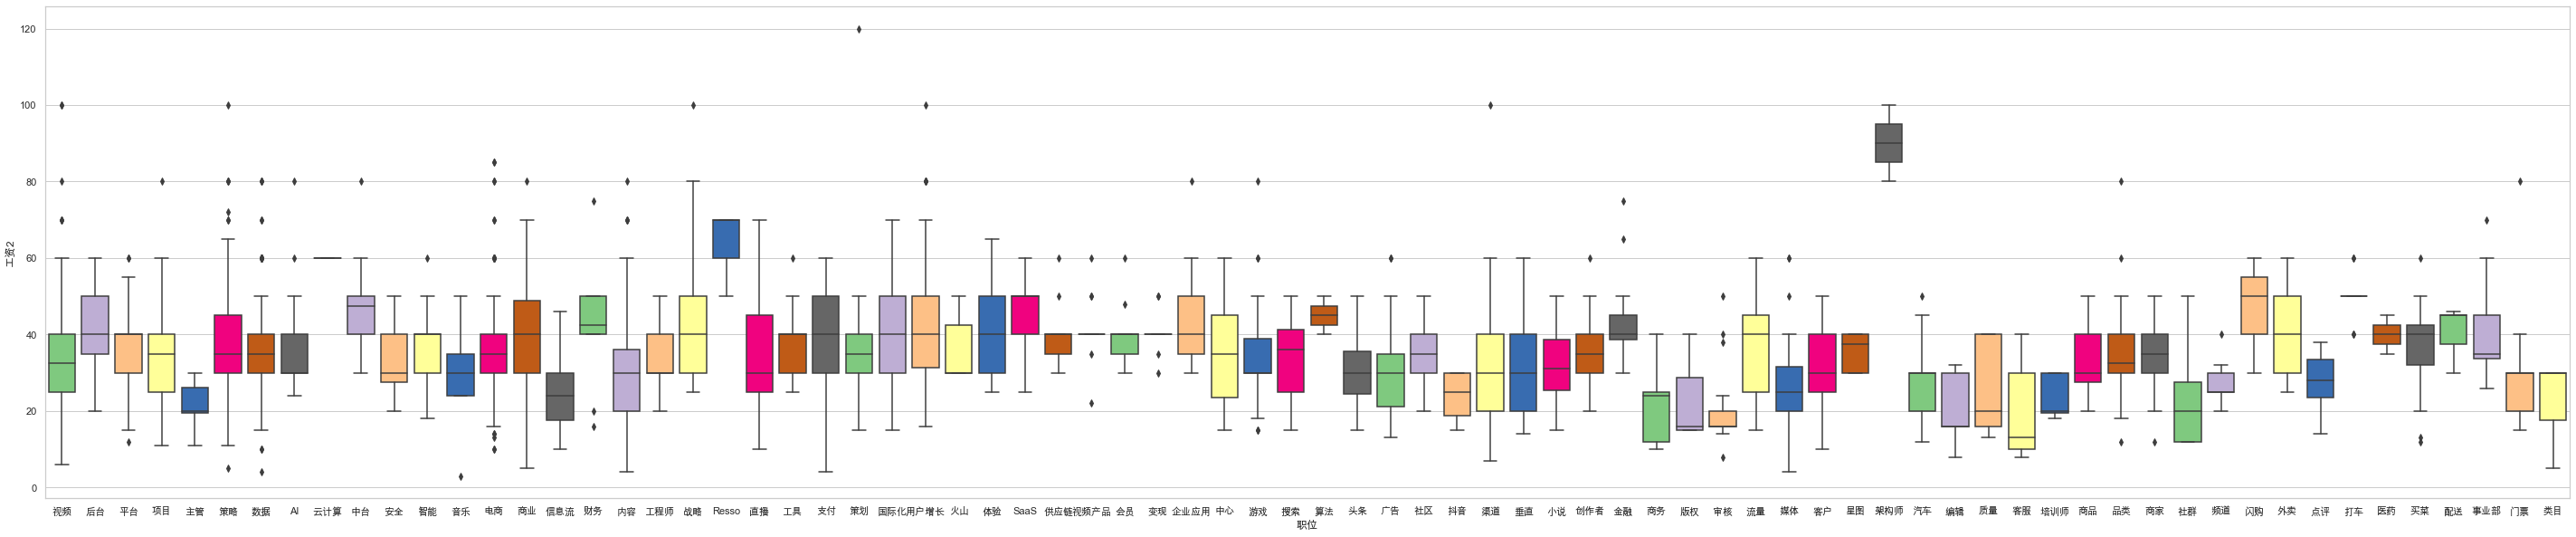

In [145]:
posi_pd_graph=posi_data_all_pd[posi_data_all_pd['职位'].isin(key_posi_word_1)]

plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资2",palette="Accent",data=posi_pd_graph,saturation=1)

### 全部职位 性价比1

<AxesSubplot:xlabel='职位', ylabel='工资1/经验1'>

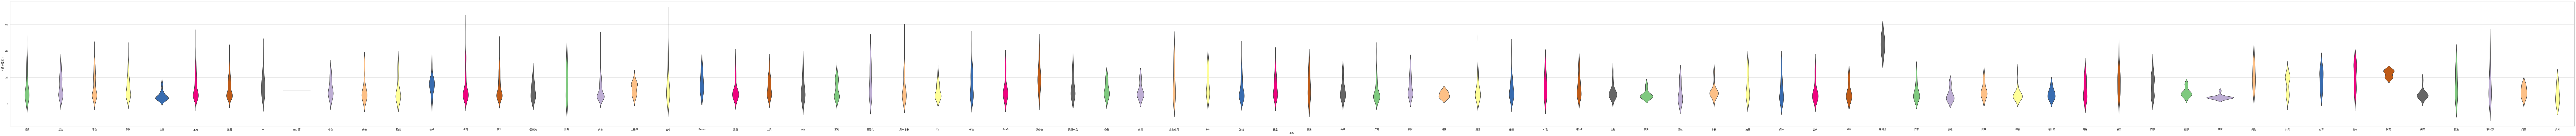

In [146]:
plt.figure(figsize=(200, 10))
sns.violinplot(x="职位",y="工资1/经验1",palette="Accent",inner=None,data=posi_pd_graph,saturation=1)

### 全部职位 性价比2

<AxesSubplot:xlabel='职位', ylabel='工资2/经验2'>

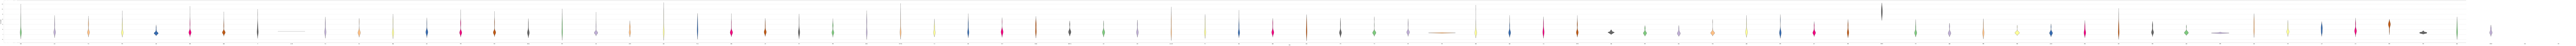

In [147]:
plt.figure(figsize=(600, 10))
sns.violinplot(x="职位",y="工资2/经验2",palette="Accent",inner=None,data=posi_pd_graph,saturation=1)

### 产品 工资1

<AxesSubplot:xlabel='职位', ylabel='工资1'>

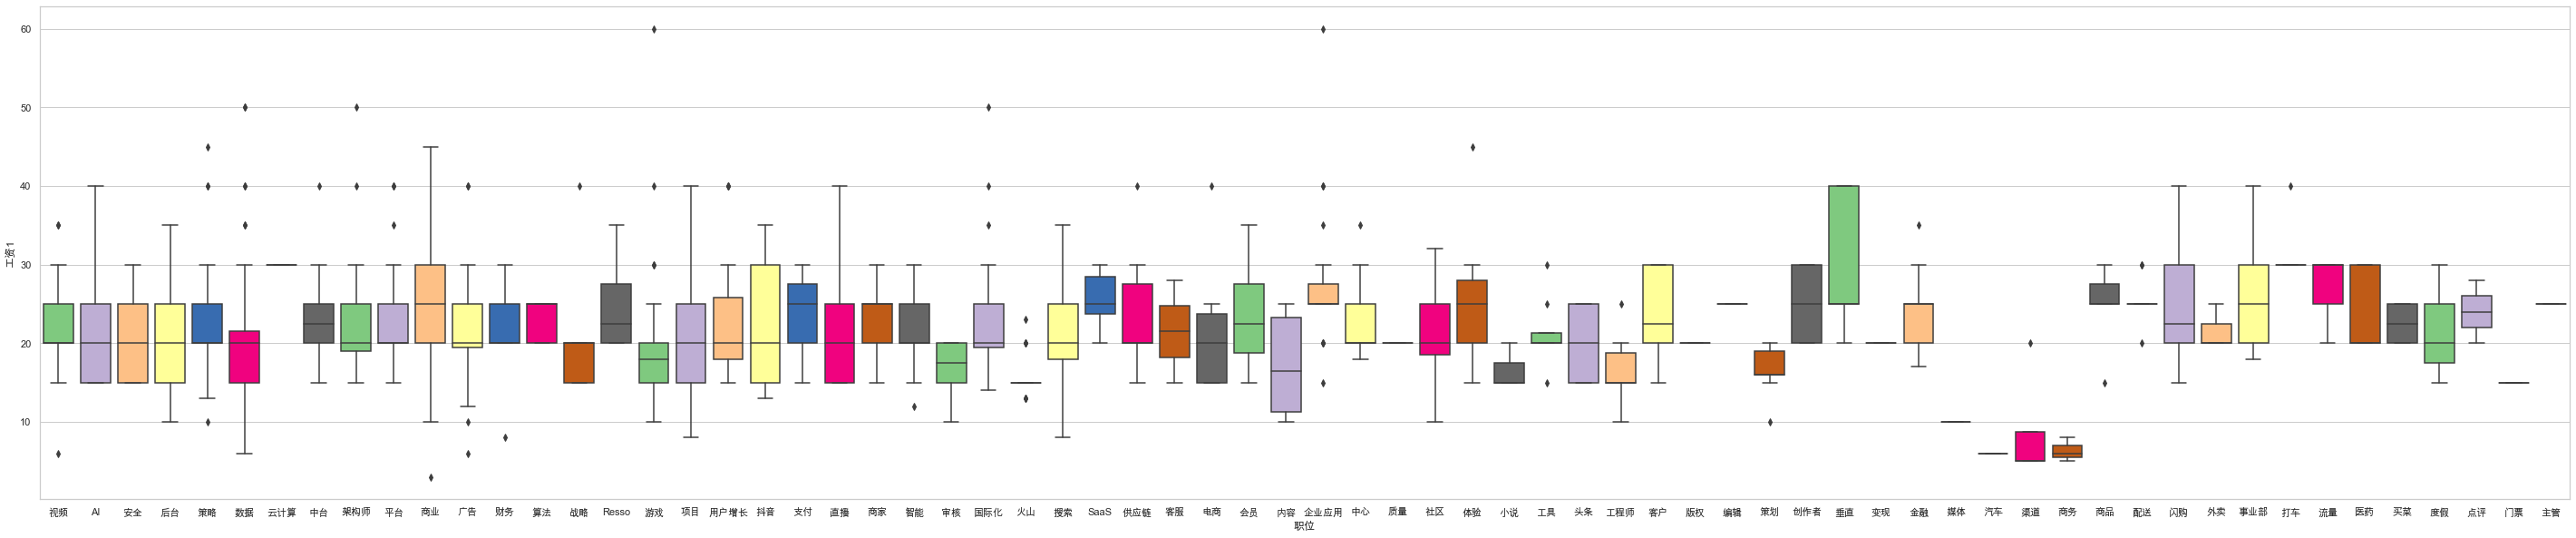

In [148]:
posi_pd_graph=posi_data_prod_pd[posi_data_prod_pd['职位'].isin(key_posi_word_1)]

plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资1",palette="Accent",data=posi_pd_graph,saturation=1)

### 产品 工资2

<AxesSubplot:xlabel='职位', ylabel='工资2'>

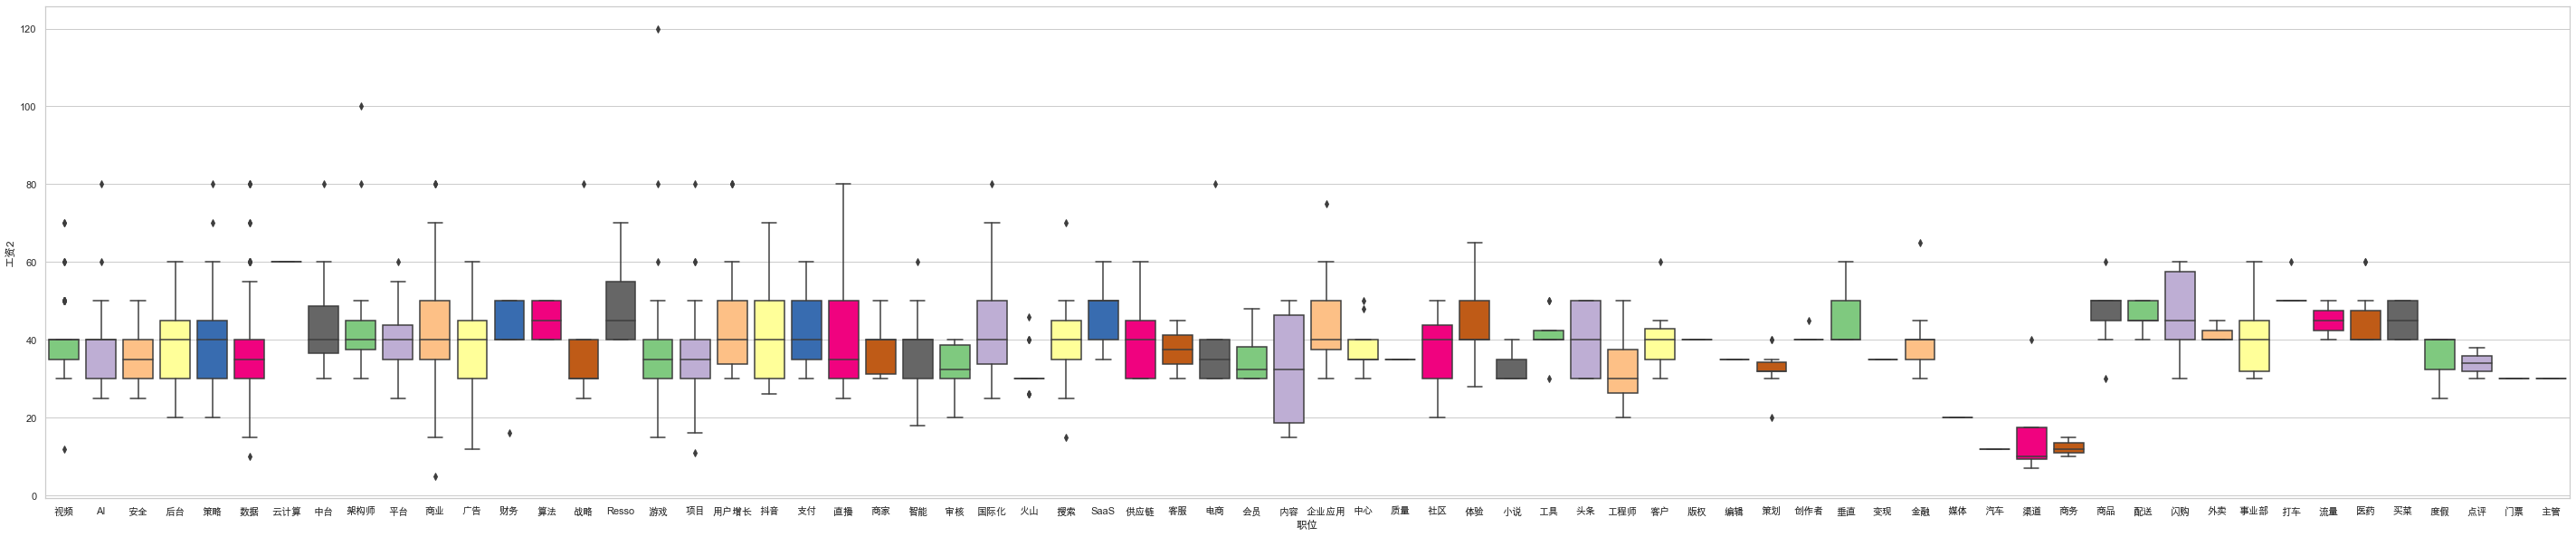

In [149]:
posi_pd_graph=posi_data_prod_pd[posi_data_prod_pd['职位'].isin(key_posi_word_1)]

plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资2",palette="Accent",data=posi_pd_graph,saturation=1)

### 产品 性价比1

<AxesSubplot:xlabel='职位', ylabel='工资1/经验1'>

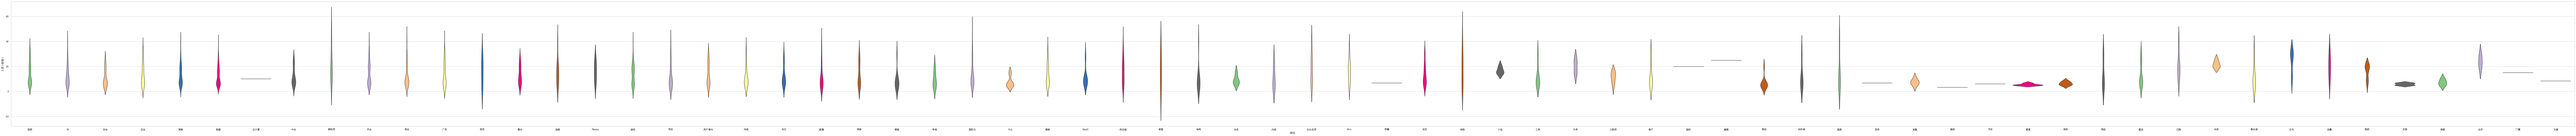

In [150]:
plt.figure(figsize=(200, 10))
sns.violinplot(x="职位",y="工资1/经验1",palette="Accent",inner=None,data=posi_pd_graph,saturation=1)

### 产品 性价比2

<AxesSubplot:xlabel='职位', ylabel='工资2/经验2'>

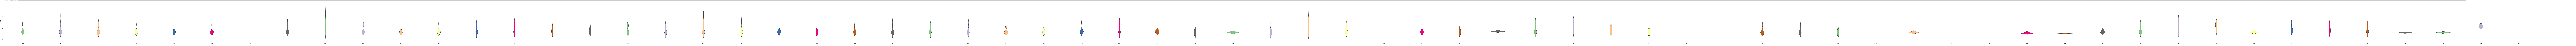

In [151]:
plt.figure(figsize=(600, 10))
sns.violinplot(x="职位",y="工资2/经验2",palette="Accent",inner=None,data=posi_pd_graph,saturation=1)

### 运营 工资1

<AxesSubplot:xlabel='职位', ylabel='工资1'>

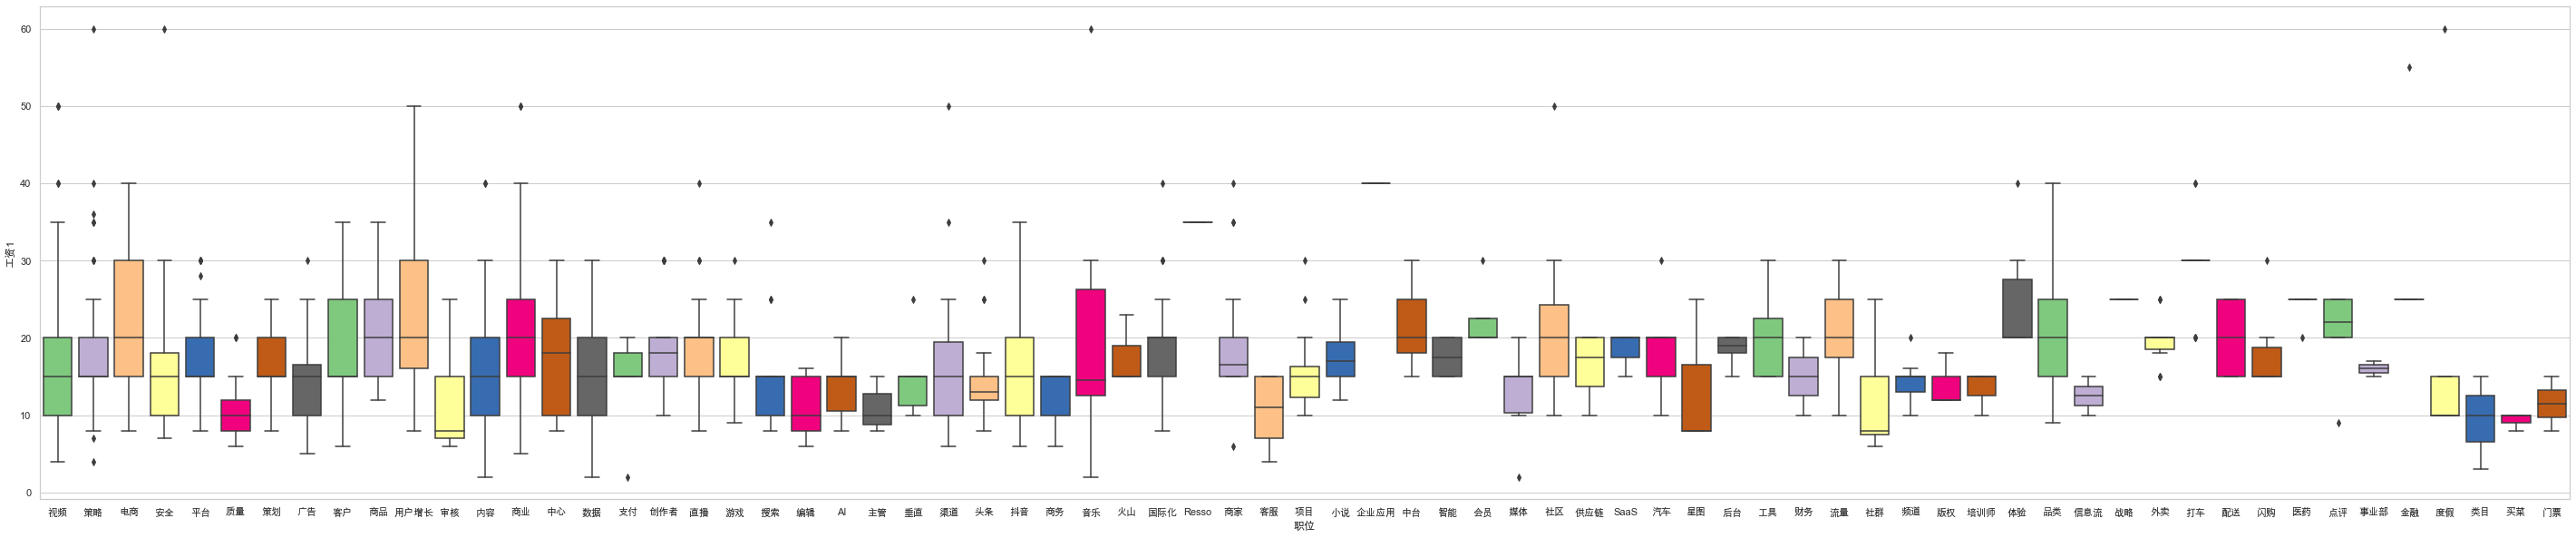

In [152]:
posi_pd_graph=posi_data_oper_pd[posi_data_oper_pd['职位'].isin(key_posi_word_1)]

plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资1",palette="Accent",data=posi_pd_graph,saturation=1)

### 运营 工资2

<AxesSubplot:xlabel='职位', ylabel='工资2'>

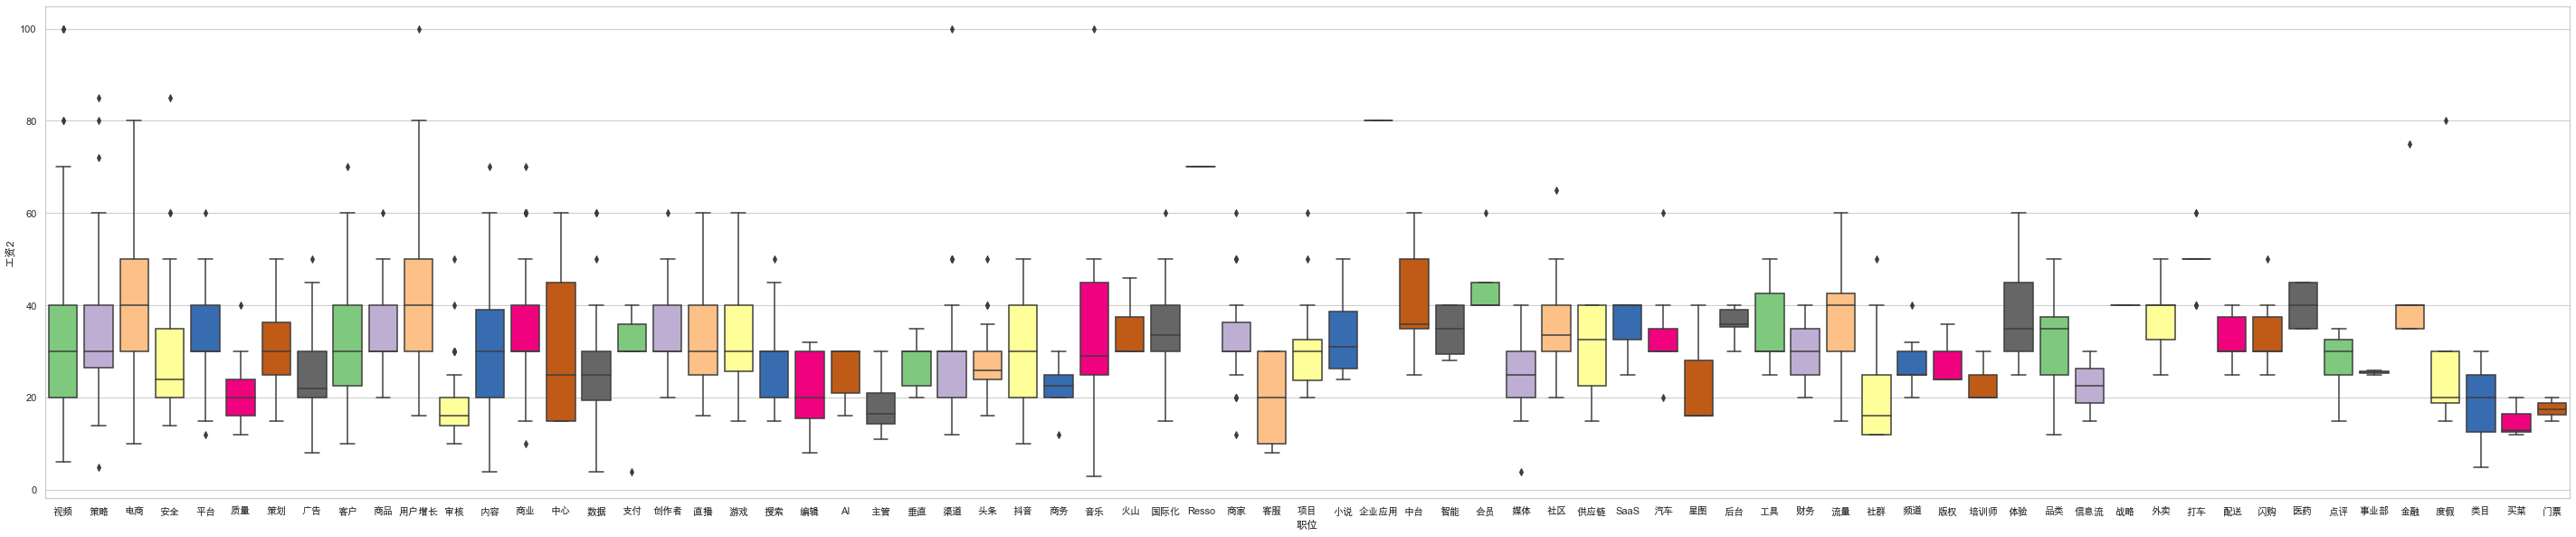

In [153]:
posi_pd_graph=posi_data_oper_pd[posi_data_oper_pd['职位'].isin(key_posi_word_1)]

plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资2",palette="Accent",data=posi_pd_graph,saturation=1)

### 运营 性价比1

<AxesSubplot:xlabel='职位', ylabel='工资1/经验1'>

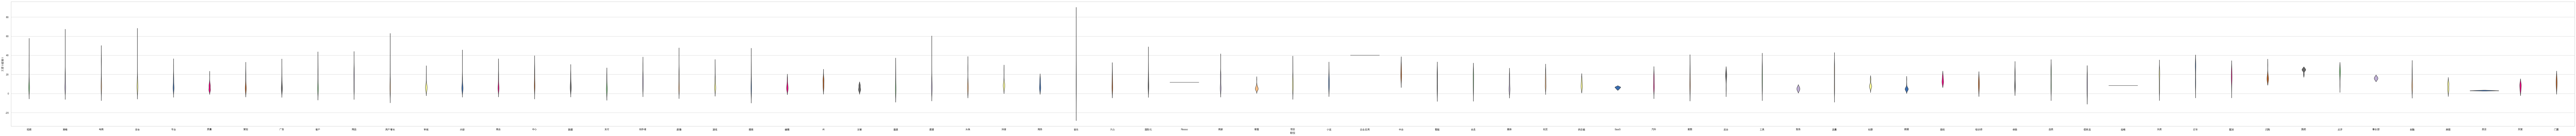

In [154]:
plt.figure(figsize=(200, 10))
sns.violinplot(x="职位",y="工资1/经验1",palette="Accent",inner=None,data=posi_pd_graph,saturation=1)

### 运营 性价比2

<AxesSubplot:xlabel='职位', ylabel='工资2/经验2'>

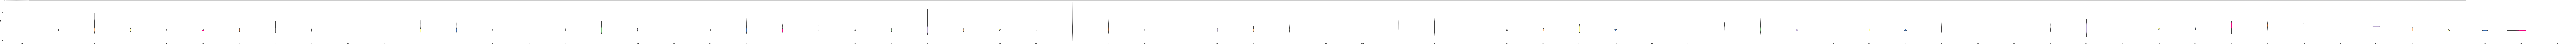

In [155]:
plt.figure(figsize=(600, 10))
sns.violinplot(x="职位",y="工资2/经验2",palette="Accent",inner=None,data=posi_pd_graph,saturation=1)

In [156]:
# posi_data_trans_pd=pd.DataFrame()
posi_data_trans_pd=data_raw.copy()

for posi in key_posi_word_2:
    index=posi_data_trans_pd.loc[posi_data_trans_pd.loc[:,'职位'].str.contains(posi),:].index
    posi_data_trans_pd.loc[index,'职位']=posi

<AxesSubplot:xlabel='职位', ylabel='工资2'>

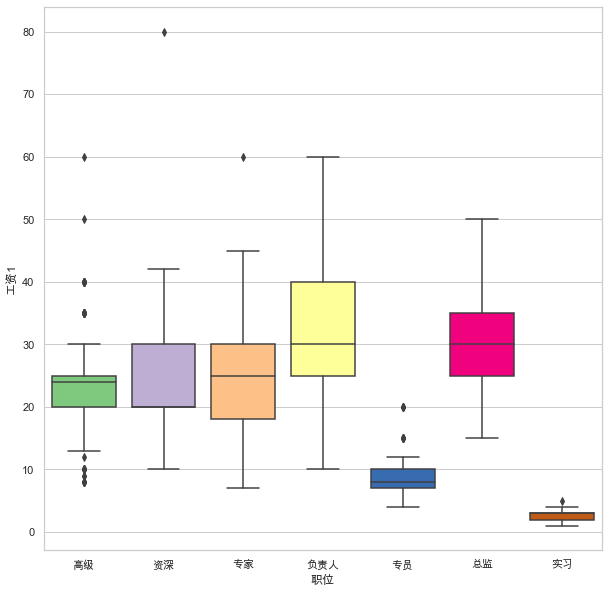

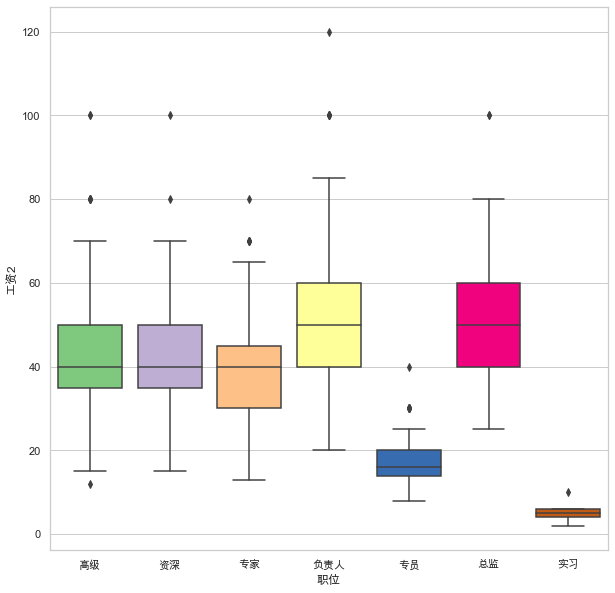

In [95]:
posi_data_trans_pd_graph=posi_data_trans_pd[posi_data_trans_pd['职位'].isin(key_posi_word_2)]

plt.figure(figsize=(10, 10))
sns.boxplot(x="职位",y="工资1",palette="Accent",data=posi_data_trans_pd_graph,saturation=1)
posi_data_trans_pd_graph=posi_data_trans_pd[posi_data_trans_pd['职位'].isin(key_posi_word_2)]

plt.figure(figsize=(10, 10))
sns.boxplot(x="职位",y="工资2",palette="Accent",data=posi_data_trans_pd_graph,saturation=1)

### 倒排 

In [96]:
key_posi_word=jieba.analyse.extract_tags(str(data_raw.sort_values(by='工资2',ascending=False).head(50)['职位']), topK=100, withWeight=False, allowPOS=('n','a','v','an','ad'))
str(key_posi_word)

"['产品', '负责人', '电商', '经理', '用户', '视频', '飞鱼', '总监', '架构师', '增长', '策略', '战略', '专家', '资深', '游戏', '企业应用', '黑灰产', '用户端', '分析师', '项目经理', '方向', '业务', '数据', '商业化', '品类', '社交', '产品线', '行业', '解决方案', '工会', '高校', '策划', '职位', '优选', '生态', '治理', '音乐', '热点', '总经理', '渠道', '保险', '规划', '商业', '安全', '内容', '支持', '技术']"

In [157]:
data_raw[data_raw['城市']=='上海'].sort_values(by='工资2',ascending=False).head(50)


,职能,公司,职位,城市,学历,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
4406,产品,阅文集团,游戏策划负责人,上海,本科,60,120,5,10,12.000000,12.000000
1311,运营,字节跳动,短视频运营总监,上海,本科,50,100,1,1,50.000000,100.000000
1305,运营,字节跳动,短视频策略运营高级经理,上海,本科,50,100,1,1,50.000000,100.000000
2102,运营,字节跳动,高级战略与经营分析师-音乐,上海,本科,60,100,1,1,60.000000,100.000000
1665,运营,字节跳动,短视频运营总监,上海,本科,50,100,1,1,50.000000,100.000000
3830,产品,美团点评,数据产品负责人,上海,本科,50,80,5,10,10.000000,8.000000
3003,运营,字节跳动,运营leader,上海,本科,60,80,1,1,60.000000,80.000000
1315,运营,字节跳动,短视频运营高级经理-社交,上海,本科,40,80,1,1,40.000000,80.000000
1002,产品,字节跳动,游戏制作人,上海,本科,40,80,1,1,40.000000,80.000000
72,产品,字节跳动,业务负责人,上海,本科,40,80,1,1,40.000000,80.000000


In [158]:
data_raw[data_raw['城市']=='北京'].sort_values(by='工资2',ascending=False).head(50)


,职能,公司,职位,城市,学历,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
1037,产品,字节跳动,PMleader-北京,北京,本科,60,100,1,1,60.000000,100.0
4220,运营,美团点评,业务运营资深专家,北京,不限,80,100,1,1,80.000000,100.0
3581,产品,美团点评,C端产品负责人,北京,本科,50,100,3,5,16.666667,20.0
1659,运营,字节跳动,飞书产品负责人-用户增长,北京,本科,50,100,1,1,50.000000,100.0
268,产品,字节跳动,产品负责人,北京,本科,60,100,1,1,60.000000,100.0
1533,运营,字节跳动,产品运营负责人,北京,本科,50,100,10,1,5.000000,100.0
1809,运营,字节跳动,飞鱼CRM产品负责人,北京,本科,60,100,1,1,60.000000,100.0
4600,产品,360,产品总经理,北京,本科,50,100,10,1,5.000000,100.0
2687,运营,字节跳动,渠道运营支持负责人,北京,本科,50,100,1,1,50.000000,100.0
2055,运营,字节跳动,电商治理策略负责人,北京,本科,60,85,1,1,60.000000,85.0


In [121]:
# data_raw.sort_values(by='工资2',ascending=False).head(50)
posi_top_pd=data_raw.sort_values(by='工资2',ascending=False).head(50)
posi_top_pd[posi_top_pd['职能']=='运营'].shape

(21, 11)

In [124]:
posi_top_pd[posi_top_pd['职能']=='运营']

,职能,公司,职位,城市,学历,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
2687,运营,字节跳动,渠道运营支持负责人,北京,本科,50,100,1,1,50.0,100.0
1305,运营,字节跳动,短视频策略运营高级经理,上海,本科,50,100,1,1,50.0,100.0
4220,运营,美团点评,业务运营资深专家,北京,不限,80,100,1,1,80.0,100.0
1311,运营,字节跳动,短视频运营总监,上海,本科,50,100,1,1,50.0,100.0
1533,运营,字节跳动,产品运营负责人,北京,本科,50,100,10,1,5.0,100.0
2102,运营,字节跳动,高级战略与经营分析师-音乐,上海,本科,60,100,1,1,60.0,100.0
1809,运营,字节跳动,飞鱼CRM产品负责人,北京,本科,60,100,1,1,60.0,100.0
1665,运营,字节跳动,短视频运营总监,上海,本科,50,100,1,1,50.0,100.0
1659,运营,字节跳动,飞书产品负责人-用户增长,北京,本科,50,100,1,1,50.0,100.0
2075,运营,字节跳动,电商安全合规负责人,北京,本科,60,85,1,1,60.0,85.0


In [122]:
posi_top_pd[posi_top_pd['职能']=='产品'].shape

(29, 11)

In [123]:
posi_top_pd[posi_top_pd['职能']=='产品']

,职能,公司,职位,城市,学历,工资1,工资2,经验1,经验2,工资1/经验1,工资2/经验2
4406,产品,阅文集团,游戏策划负责人,上海,本科,60,120,5,10,12.000000,12.0
4600,产品,360,产品总经理,北京,本科,50,100,10,1,5.000000,100.0
1037,产品,字节跳动,PMleader-北京,北京,本科,60,100,1,1,60.000000,100.0
268,产品,字节跳动,产品负责人,北京,本科,60,100,1,1,60.000000,100.0
3581,产品,美团点评,C端产品负责人,北京,本科,50,100,3,5,16.666667,20.0
1245,产品,字节跳动,产品架构师/Leader-飞书,杭州,本科,50,100,1,1,50.000000,100.0
1246,产品,字节跳动,教育行业产品leader,北京,本科,40,80,1,1,40.000000,80.0
1247,产品,字节跳动,产品leader--高校,北京,本科,40,80,1,1,40.000000,80.0
1248,产品,字节跳动,KA产品leader,北京,本科,40,80,1,1,40.000000,80.0
3545,产品,美团点评,商业分析leader-保险产品线,北京,本科,40,80,10,1,4.000000,80.0


<AxesSubplot:xlabel='职位', ylabel='工资2'>

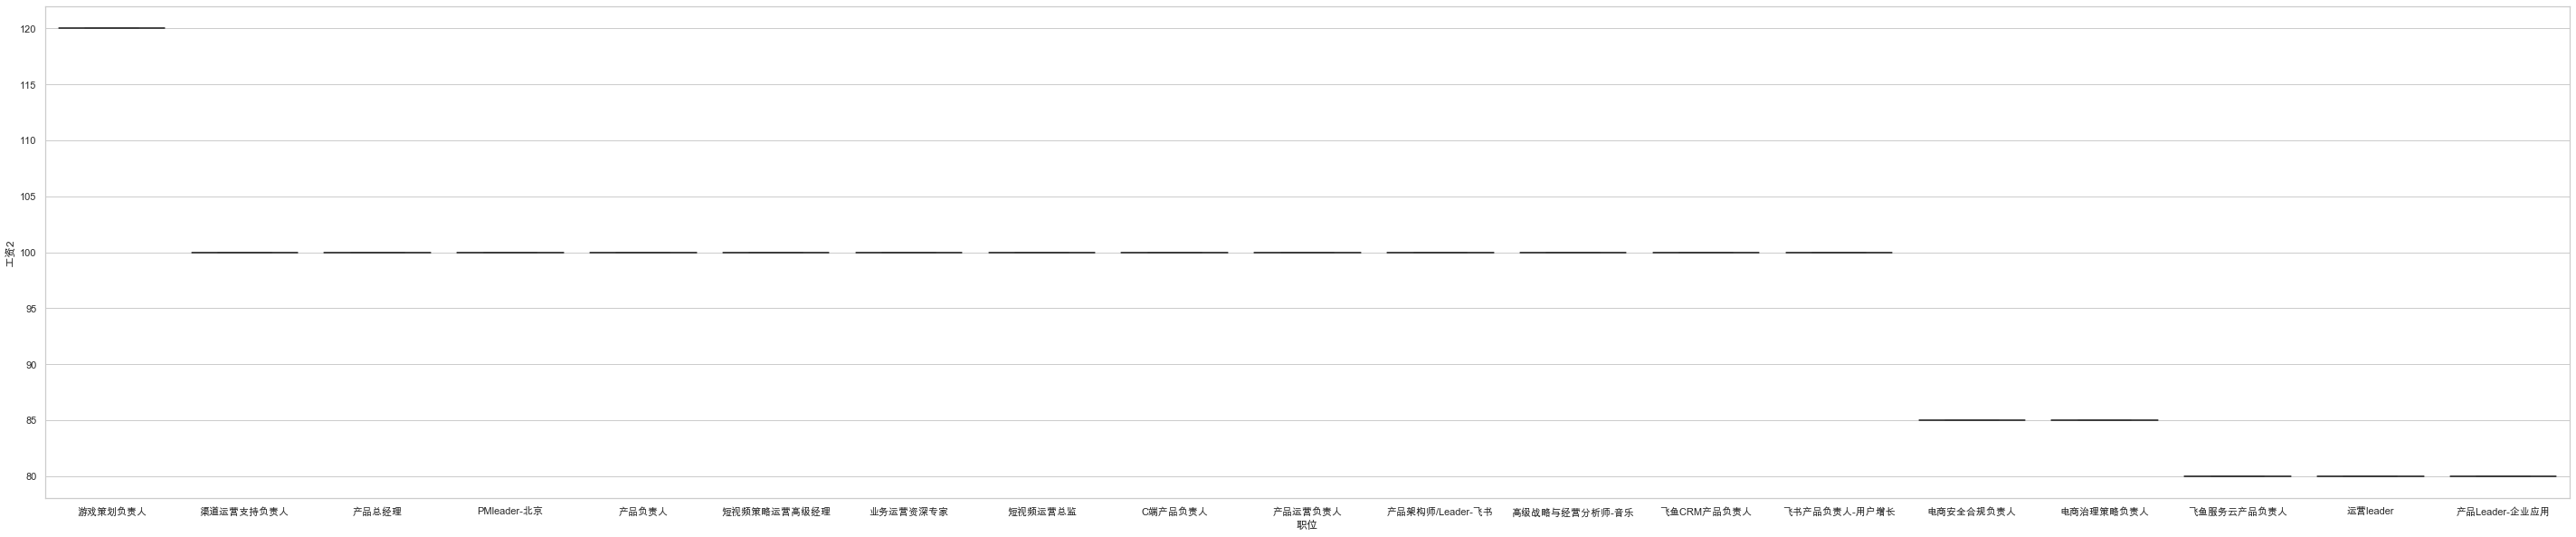

In [98]:
plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资2",palette="Accent",data=data_raw.sort_values(by='工资2',ascending=False).head(20)
,saturation=1)

In [99]:
key_posi_word=jieba.analyse.extract_tags(str(data_raw.sort_values(by='工资1',ascending=False).head(50)['职位']), topK=100, withWeight=False, allowPOS=('n','a','v','an','ad'))
str(key_posi_word)

"['负责人', '产品', '电商', '用户', '专家', '视频', '策略', '企业应用', '用户端', '经理', '资深', '生态', '总监', '打车', '商业', '增长', '管理室', '地图', '架构师', '黑灰产', '闪购', '服务部', '业务', '副经理', '飞鱼', '商业化', '品类', '运力', '度假', '启蒙', '门票', '解决方案', '公交', '商家', '策划', '职位', '社区', '优选', '理财产品', '体验', '游戏', '财务', '信用', '治理', '账户', '音乐', '热点', '总经理', '渠道', '模式', '分析师', '战略', '安全', '金融', '内容', '支持', '数据', '行业']"

<AxesSubplot:xlabel='职位', ylabel='工资2'>

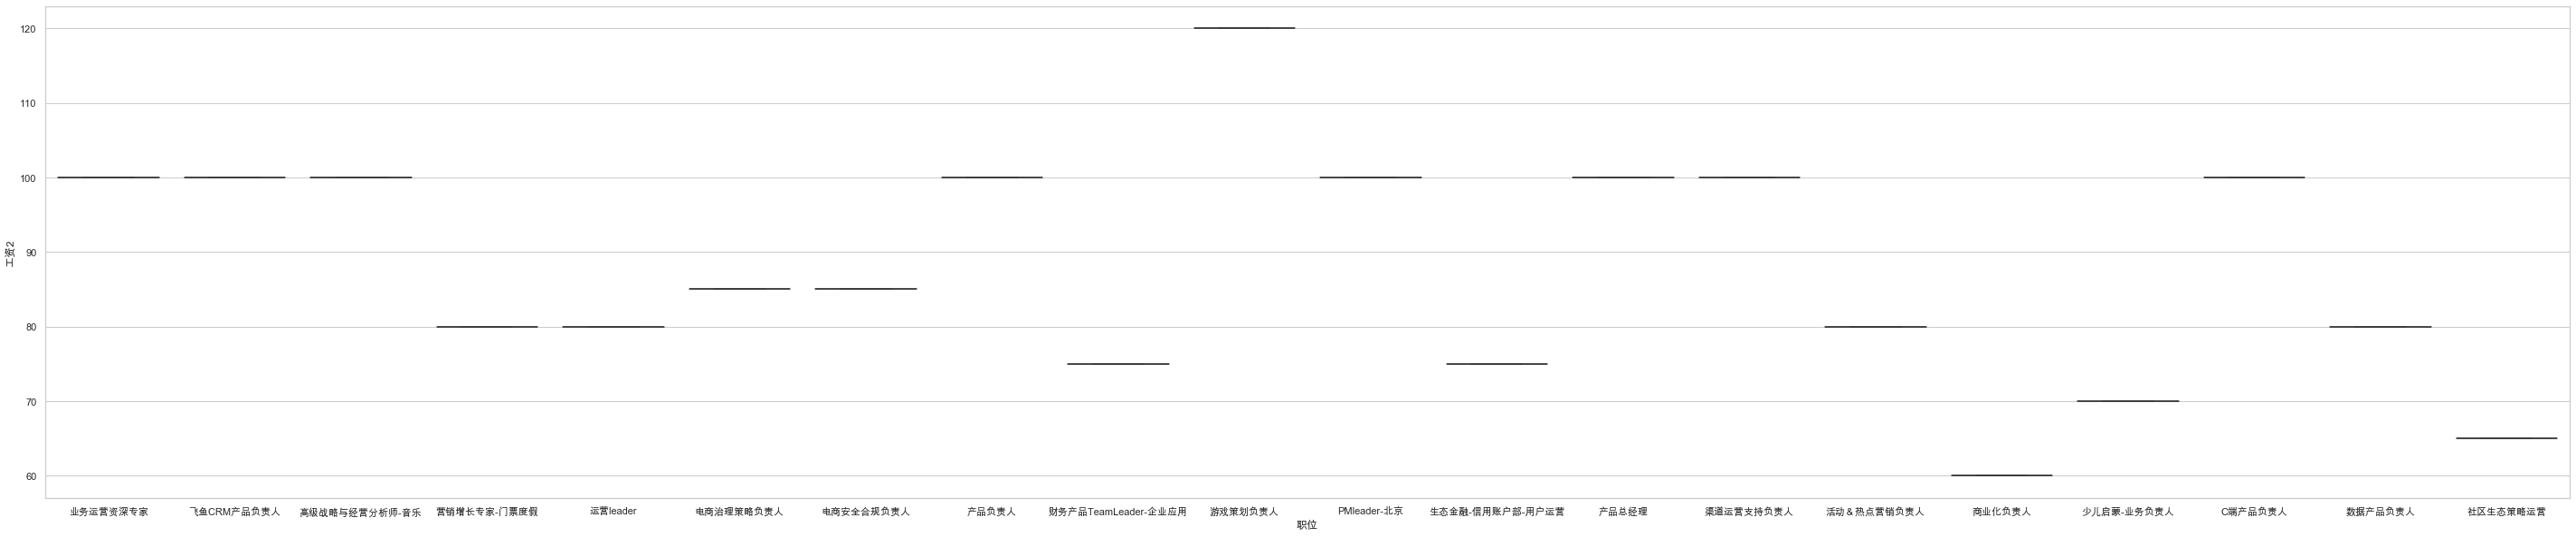

In [100]:
plt.figure(figsize=(50, 10))
sns.boxplot(x="职位",y="工资2",palette="Accent",data=data_raw.sort_values(by='工资1',ascending=False).head(20)
,saturation=1)

# 公司

<AxesSubplot:xlabel='公司', ylabel='工资1'>

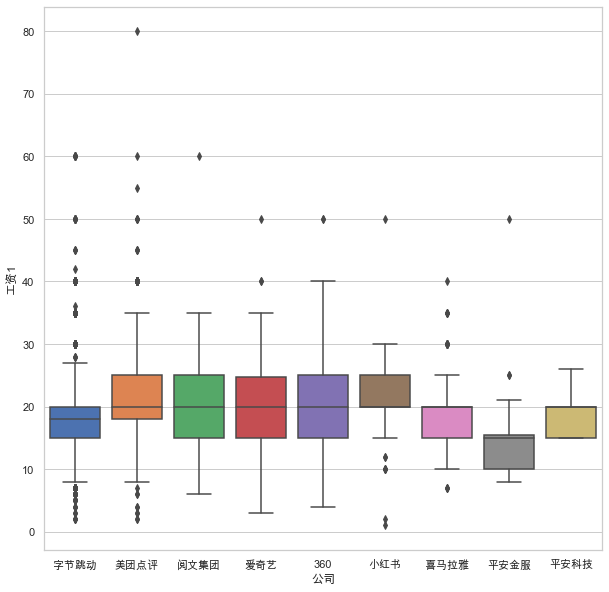

In [101]:
plt.figure(figsize=(10, 10))
sns.boxplot(x="公司",y="工资1",data=data_raw,saturation=1)

<AxesSubplot:xlabel='公司', ylabel='工资2'>

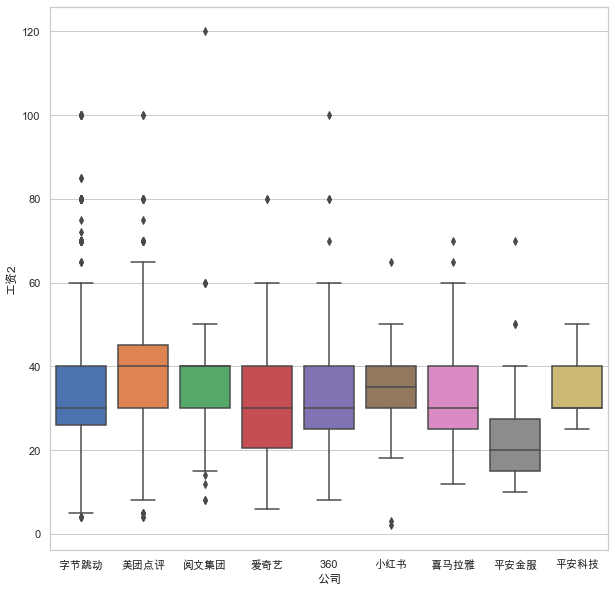

In [102]:
plt.figure(figsize=(10, 10))
sns.boxplot(x="公司",y="工资2",data=data_raw,saturation=1)